In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_squared_error
from plotly.offline import  iplot

import warnings
warnings.filterwarnings('ignore')

In [318]:
path = '../dasatet_5/BritishMart.csv'

bm = pd.read_csv(path)

In [319]:
bm['tanggal'] = pd.to_datetime(bm['tanggal'])

# **CEK MISSING VALUE**

In [320]:
missing_values = bm.isnull().sum()
print("Jumlah missing value di setiap kolom:\n", missing_values)

Jumlah missing value di setiap kolom:
 nama_toko         0
harga_pound       0
harga_per_unit    0
unit              0
nama              0
kategori          0
brand_sendiri     0
tanggal           0
dtype: int64


In [321]:
bm_empty = bm[bm.isna().any(axis=1)]

In [322]:
bm_empty

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal


In [323]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nama_toko       979866 non-null  object        
 1   harga_pound     979866 non-null  float64       
 2   harga_per_unit  979866 non-null  float64       
 3   unit            979866 non-null  object        
 4   nama            979866 non-null  object        
 5   kategori        979866 non-null  object        
 6   brand_sendiri   979866 non-null  bool          
 7   tanggal         979866 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(2), object(4)
memory usage: 53.3+ MB


# **CEK DUPLICATE VALUE**

In [324]:
duplicate_rows = bm.duplicated()
num_duplicate_rows = duplicate_rows.sum()
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 18


In [325]:
duplicate_rows = bm[bm.duplicated()]
print(duplicate_rows)

          nama_toko  harga_pound  harga_per_unit  unit  \
979480  BritishMart        14.00           14.00  unit   
979505  BritishMart         9.00            9.00  unit   
979508  BritishMart        15.00           15.00  unit   
979534  BritishMart        10.00           10.00  unit   
979557  BritishMart         4.60            4.60  unit   
979558  BritishMart        12.00           12.00  unit   
979559  BritishMart         5.00            5.00  unit   
979584  BritishMart         5.00            5.00  unit   
979635  BritishMart         7.00            7.00  unit   
979685  BritishMart         4.60            4.60  unit   
979686  BritishMart         4.60            4.60  unit   
979710  BritishMart        12.00           12.00  unit   
979735  BritishMart         5.25            5.25  unit   
979736  BritishMart         3.50            3.50  unit   
979787  BritishMart        32.00           32.00  unit   
979812  BritishMart         3.20            3.20  unit   
979836  Britis

Tapi ini tu bukan duplicate value gasiiiii, soalnya beda-beda juga, gatau kenapa ke-detect duplicate value :(

# **STANDARISASI KATEGORI DENGAN MODUS**

In [326]:
mode_kategori = bm.groupby('nama')['kategori'].agg(lambda x: x.mode()[0])
bm = pd.merge(bm, mode_kategori, how='left', on='nama', suffixes=('', '_mode'))
bm['kategori'] = bm['kategori_mode']
bm.drop(columns=['kategori_mode'], inplace=True)

In [327]:
bm

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
0,BritishMart,1.35,1.35,l,Alpro Oat Long Life Drink,drinks,False,2021-01-01
1,BritishMart,2.10,2.10,l,Alpro Almond Chilled Drink,free-from,False,2021-01-01
2,BritishMart,1.00,0.70,l,Volvic Touch of Fruit Strawberr…,drinks,False,2021-01-01
3,BritishMart,2.10,2.10,l,Alpro Soya Chilled Drink,free-from,False,2021-01-01
4,BritishMart,1.00,0.70,l,Volvic Touch of Fruit Lemon & Lim…,drinks,False,2021-01-01
...,...,...,...,...,...,...,...,...
979861,BritishMart,9.50,9.50,unit,Morrisons Wooden Rectangular Paddleboard,home,True,2022-02-26
979862,BritishMart,3.00,3.00,unit,Morrisons Wooden Turner,home,True,2022-02-27
979863,BritishMart,2.00,2.00,unit,Talking Tables Metallic Gold Slogan Napkin,home,False,2022-02-28
979864,BritishMart,25.00,25.00,unit,Tcp Smart Led Double Switch,home,False,2022-03-01


In [328]:
bm_cleaned = bm.loc[:,['harga_per_unit', 'nama', 'kategori', 'tanggal', 'brand_sendiri']]
bm_cleaned['tanggal'] = pd.to_datetime(bm_cleaned['tanggal'])
bm_cleaned.index = bm_cleaned.pop('tanggal')
bm_cleaned.sort_index(inplace=True)

In [329]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,False
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,False
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,False
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,False
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,False
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,False
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,False
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,False


# **EDA**

In [330]:
# Mengelompokkan data berdasarkan tanggal dan menjumlahkan harga per unit
daily_price = bm.groupby('tanggal', as_index=False)['harga_per_unit'].sum()

# Membuat scatter plot dari data harian
daily_price_sc = go.Scatter(x=daily_price['tanggal'], y=daily_price['harga_per_unit'])

# Menentukan layout dari grafik
layout = go.Layout(title='Daily Price at British Mart', xaxis=dict(title='Date'), yaxis=dict(title='Price'))

# Membuat dan menampilkan grafik
fig = go.Figure(data=[daily_price_sc], layout=layout)
iplot(fig)

# **GROUPING BY KATEGORI**

In [331]:
kategori_values = bm['kategori'].value_counts()
kategori_values

kategori
food_cupboard      234178
health_products    156673
home               144550
drinks             130457
fresh_food         114421
household           45737
frozen              41089
pets                38514
baby_products       35043
bakery              19982
free-from           19222
Name: count, dtype: int64

# **HEALTH PRODUCTS**

In [332]:
hp_data = bm_cleaned[bm_cleaned['kategori'] == 'health_products']
harga_per_unit_daily = hp_data[['harga_per_unit']]
health = harga_per_unit_daily.groupby(harga_per_unit_daily.index).mean()

# **MOVING AVERAGE & SHIFT FUNCTION**

In [333]:
health['moving_avg_per_triduum'] = health['harga_per_unit'].rolling(window=3).mean()
health['moving_avg_per_triduum'] = health['moving_avg_per_triduum'].fillna(0)

In [334]:
# Shift for n+1 - n-1
health['prev_harga'] = health['harga_per_unit'].shift(1)
health['next_harga'] = health['harga_per_unit'].shift(-1)

health['increase'] = 0  # Initialize with 0
mask = health.index != health.index[0]
mask &= health.index != health.index[-1]
health.loc[mask, 'increase'] = (health['harga_per_unit'] - health['prev_harga']) + (health['next_harga'] - health['harga_per_unit'])

health['increase'].iloc[0] = 0
health['increase'].iloc[-1] = 0

health = health.drop(columns=['prev_harga', 'next_harga'])

# **SPLIT TRAIN (80%) TEST (20%)**

In [335]:
train_food = health.loc[health.index < '2023-07-31']
test_food = health.loc[health.index >= '2023-07-31'] 

print(f'Number of days in train data: {len(train_food)}')
print(f'Number of days in test data: {len(test_food)}')

Number of days in train data: 852
Number of days in test data: 213


In [336]:
trace_train = go.Scatter(x=train_food.index, y=train_food['harga_per_unit'], mode='lines', name='Train')
trace_test = go.Scatter(x=test_food.index, y=test_food['harga_per_unit'], mode='lines', name='Test')

layout = go.Layout(title='Train and Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'))
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

fig.show()

# **FEATURE CREATION**

In [337]:
def create_features(data):
    data['dayofweek']= data.index.dayofweek
    data['quarter']= data.index.quarter
    data['month']= data.index.month
    data['year']= data.index.year
    data['dayofyear']= data.index.dayofyear
    return data

health = create_features(health)

<Axes: xlabel='month', ylabel='harga_per_unit'>

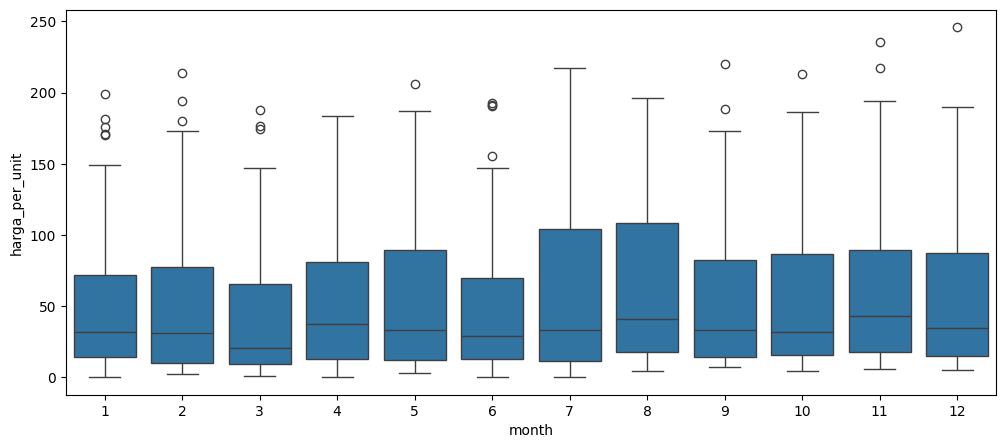

In [338]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=health, x='month', y='harga_per_unit')

In [339]:
train = create_features(train_food)
test = create_features(test_food)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'increase', 'moving_avg_per_triduum']
TARGET = 'harga_per_unit'

In [340]:
# Split to X and y
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# **MODELLING**

In [354]:
# Fit Auto ARIMA model
exogenous = ['moving_avg_per_triduum', 'increase', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

auto_am = auto_arima(train['harga_per_unit'], exogenous=train[exogenous], trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)
auto_am.summary()

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=9198.003, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=9090.887, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=9132.362, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=9120.000, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=9086.766, Time=0.21 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  852
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -4506.086
Date:                Sat, 18 May 2024   AIC                           9026.171
Time:                        08:53:48   BIC                           9059.396
Sample:                             0   HQIC                          9038.897
                                - 852                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1270      2.005     -0.063      0.949      -4.057       3.803
ar.L1         -0.4150      0.037    -11.267      0.000      -0.487      -0.343
ar.L2         -0.2701      0.041     -6.580      0.000      -0.351      -0.190
ar.L3         -0.3112      0.037     -8.310      0.000      -0.385      -0.238
ar.L4         -0.2927      0.038     -7.623      0.000      -0.368      -0.217
ar.L5         -0.1010      0.041     -2.469      0.014      -0.181      -0.021
sigma2      2320.7650    116.893     19.854      0.000    2091.660    2549.870
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                36.05
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.26
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **FITTING**

In [342]:
from statsmodels.tsa.arima.model import ARIMA

In [369]:
# Best model: ARIMA(2,0,3)(0,0,0)[0]
model = ARIMA(train['harga_per_unit'], order=(2, 0, 9), exog=train[exogenous])
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         harga_per_unit   No. Observations:                  852
Model:                 ARIMA(2, 0, 9)   Log Likelihood               -3916.375
Date:                Sat, 18 May 2024   AIC                           7872.750
Time:                        08:55:15   BIC                           7967.701
Sample:                             0   HQIC                          7909.117
                                - 852                                         
Covariance Type:                  opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3177.4231    670.570      4.738      0.000    1863.130    4491.716
moving_avg_per_triduum     1.0880      0.009    116.977      0.000       1.070       1.106
increase                   0.4710      0.014     32.762      0.000       0.443       0.499
dayofweek                  0.0534      0.564      0.095      0.925      -1.052       1.159
quarter                   -1.2080      0.764     -1.582      0.114      -2.705       0.289
month                      2.9068      0.945      3.077      0.002       1.055       4.759
year                      -1.5737      0.332     -4.744      0.000      -2.224      -0.924
dayofyear                 -0.0897      0.029     -3.059      0.002      -0.147      -0.032
ar.L1                      0.3112      0.905      0.344      0.731      -1.462       2.085
ar.L2                     -0.0584      0.620     -0.094      0.925      -1.274       1.157
ma.L1                     -1.0157      0.904     -1.124      0.261      -2.787       0.756
ma.L2                     -0.2510      1.208     -0.208      0.835      -2.618       2.116
ma.L3                      0.3957      0.262      1.508      0.132      -0.119       0.910
ma.L4                     -0.0716      0.542     -0.132      0.895      -1.134       0.991
ma.L5                      0.2728      0.138      1.972      0.049       0.002       0.544
ma.L6                     -0.1771      0.229     -0.773      0.440      -0.626       0.272
ma.L7                      0.0595      0.250      0.238      0.812      -0.430       0.549
ma.L8                     -0.0148      0.078     -0.191      0.849      -0.167       0.137
ma.L9                     -0.0730      0.071     -1.030      0.303      -0.212       0.066
sigma2                   640.4341     33.303     19.231      0.000     575.162     705.706
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                34.47
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.21
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **FORECASTING**

In [370]:
start = len(train)
end = len(train) + len(test)-1
forecast = model.predict(start=start,
                         end=end,
                         exog=test[exogenous])

In [371]:
forecast_df = pd.DataFrame(forecast.values, index=test.index, columns=['forecast'])

health_forecast = pd.concat([health, forecast_df], axis=1)
forecast_test = pd.concat([test, forecast_df], axis=1)

In [372]:
health_forecast

,harga_per_unit,moving_avg_per_triduum,increase,dayofweek,quarter,month,year,dayofyear,forecast
tanggal,,,,,,,,,
2021-01-01,3.600000,0.000000,0.000000,4,1,1,2021,1,NaN
2021-01-02,7.000000,0.000000,13.445455,5,1,1,2021,2,NaN
2021-01-04,17.045455,9.215152,-4.600000,0,1,1,2021,4,NaN
2021-01-06,2.400000,8.815152,43.982670,2,1,1,2021,6,NaN
2021-01-07,61.028124,26.824526,146.522376,3,1,1,2021,7,NaN
...,...,...,...,...,...,...,...,...,...
2024-02-25,39.062632,119.652765,-130.726616,6,1,2,2024,56,60.667750
2024-02-26,41.569630,84.309502,-5.044382,0,1,2,2024,57,81.004048
2024-02-27,34.018250,38.216837,-33.525219,1,1,2,2024,58,17.406328


In [374]:
# Entire test
filtered_data = health_forecast.loc[(health_forecast.index > '2023-07-31') & (health_forecast.index <= '2024-02-29')]

# Plotting
trace1 = go.Scatter(x=filtered_data.index, y=filtered_data['harga_per_unit'], mode='lines', name='Truth Data')
trace2 = go.Scatter(x=filtered_data.index, y=filtered_data['forecast'], mode='markers', name='ARIMA Predictions')
layout = go.Layout(title='Entire Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'), legend=dict(x=0, y=1))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# **CALCULATE ERROR**

In [375]:
score = np.sqrt(mean_squared_error(forecast_test['harga_per_unit'], forecast_test['forecast']))

In [376]:
forecast_test['error'] = np.abs(forecast_test[TARGET] - forecast_test['forecast'])
forecast_test['date'] = forecast_test.index.date

In [377]:
# Worst predicted
forecast_test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2023-11-11    136.505131
2023-10-19    123.346206
2023-12-03    121.458465
2023-09-26    119.236856
2024-01-12    114.594172
Name: error, dtype: float64

In [378]:
# Best predicted
forecast_test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2023-12-29    0.052938
2024-01-21    0.059064
2024-02-14    0.170964
2023-12-06    0.347065
2023-08-13    0.351345
Name: error, dtype: float64

In [379]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

actual_values = health_forecast['harga_per_unit']
predicted_values = health_forecast['forecast']
mape = calculate_mape(actual_values, predicted_values)
MSE = forecast_test['error'].mean()

results = pd.DataFrame({
    'Metric': ['MSE', 'MAPE'],
    'Value': [MSE, f"{mape.round(2)}%"]
})

In [380]:
print("======ARIMA Model Result======")
print(results)

======ARIMA Model Result======
  Metric      Value
0    MSE  25.765036
1   MAPE     84.91%


# **NOTE**

Entah kenapa waktu pake kategori foodcup, best model nya 2,0,3. Hasil skor nya masih logis, MSE 20, MAPE 80%. Tapi waktu pake auto arima ke health_products, dapet 0,1,1. MSE nya ribuan dan MAPE nya 1800%.  